In [1]:
import root_pandas as rp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import mytools

Welcome to JupyROOT 6.18/00


# Create an arrow pointing in the + z-direction

In [2]:
body_l = 35
body_r = 2

head_l = 20
head_r = 0.15

x_vals, y_vals, z_vals = [],[],[]

for x_ind in range(120):
    for y_ind in range(120):
        for z_ind in range (120):
            
            # Add body of arrow
            if ( (x_ind-60)**2 + (y_ind-60)**2 ) < body_r**2:
                if ( (60- body_l ) < z_ind ) and ( 60 > z_ind ):
                    
                    x_vals += [x_ind]
                    y_vals += [y_ind]
                    z_vals += [z_ind]
                    
            # Add head of arrow
            if ( (60- head_l ) < z_ind ) and ( 60 > z_ind ):
                if (x_ind-60)**2 + (y_ind-60)**2 <  ( head_r * (z_ind-60)**2 ) :
                    x_vals += [x_ind]
                    y_vals += [y_ind]
                    z_vals += [z_ind+head_l]

# Mean-center the arrow           
mean_x = np.mean(x_vals)
mean_y = np.mean(y_vals)
mean_z = np.mean(z_vals)

x_new = x_vals-mean_x
y_new = y_vals-mean_y
z_new = z_vals-mean_z

                

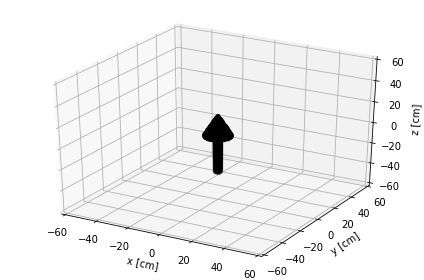

In [3]:
# Raw simulations start at the origin and the initial direction is along the z-axis
mytools.plot_arrow(x_points =x_new, y_points = y_new, z_points = z_new )



# Rotate arrow to a random direction

In [4]:
df_rot = pd.DataFrame(columns = ['x', 'y', 'z', 'dir'])

for index in range(10):

    # Determine random direction to rotate to
    to_dir, theta, phi = mytools.random_three_vector()
    
    # Rotate all points to random direction drawn in previous step
    Rcoords = mytools.R_z(phi)@mytools.R_y(theta)@np.array((x_new,y_new,z_new))
   
    # Store transformed positions and new dataframe
    df_rot = df_rot.append({'x' : Rcoords[0], 'y' : Rcoords[1], 'z' : Rcoords[2], 'dir': to_dir }, ignore_index = True)
    
df_rot.head()

,x,y,z,dir
0,"[-2.2251828421991964, -1.482030387884769, -0.7...","[-0.5176183721024459, 0.15150376147739852, 0.8...","[6.921996354462831, 6.921996354462831, 6.92199...","[0.654376811244798, -0.7267757393127564, 0.208..."
1,"[0.6391881191474066, 1.5634257022065379, 2.487...","[6.785333659096539, 6.4035157835838605, 6.0216...","[2.5853600667266416, 2.5853600667266416, 2.585...","[-0.122144204510215, -0.2956652152799815, 0.94..."
2,"[-6.1767354737701385, -5.975879519879939, -5.7...","[-0.775163119012492, 0.20445766771411586, 1.18...","[3.7921579631582873, 3.7921579631582873, 3.792...","[0.4863262358985362, -0.09971360483236798, 0.8..."
3,"[4.004728260537573, 4.210774046636545, 4.41681...","[2.887107929161914, 1.9085655774822043, 0.9300...","[5.362850021786413, 5.362850021786413, 5.36285...","[-0.7148136844158594, -0.15051402452530427, 0...."
4,"[-4.010187919031248, -3.3485878159146796, -2.6...","[-0.8710205635439026, -1.6208774189210786, -2....","[6.024376899189816, 6.024376899189816, 6.02437...","[-0.6635677493243022, -0.5854670637864113, -0...."


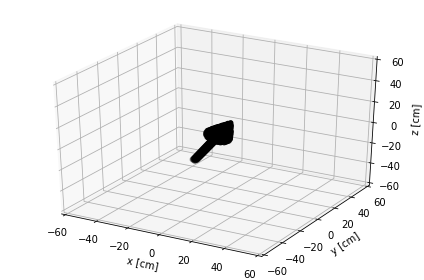

In [5]:
# Visualize a randomly rotated arrow

# Select recoil index
i = 2

# Raw simulations start in the origin and the initial direction is now provided in the dataframe
mytools.plot_arrow(x_points = df_rot.iloc[i]['x'], y_points = df_rot.iloc[i]['y'], z_points = df_rot.iloc[i]['z'])


# Convert into Sparse Tensor

In [6]:
# For now we test on one arrow
track = df_rot.iloc[i]

# Here a define the pixel grid parameters
# This is defined to be consistent with the electron recoil simulations
eff_l = 60
# Voxel size in cm
vox_l = 1

# Number of voxels along 1 dim
Npix = round(eff_l*2/vox_l) 
# Tensor dimensions, there is an extra dimension for color which is not used
# note that I do not use (1,Npix,Npix,Npix). This is because of the spconv layers that I use do not like this format
# I need to reshape if I want to use this data to make dense tensors!!!!
dim = (Npix,Npix,Npix,1)


# compute the indices for the sparse tensor
indices = torch.stack( ( (torch.tensor(track['x'])+eff_l)/vox_l  , (torch.tensor(track['y'])+eff_l)/vox_l, (torch.tensor(track['z'])+eff_l)/vox_l ) ).type(torch.int16)

if torch.min(indices) < 0 or torch.max(indices) >= Npix:
    print("Warning: Arrow not contained")

else:
    values = torch.ones( (len(track['x']), 1) ).type(torch.float)
    vg = torch.sparse_coo_tensor(indices, values, dim)

    # Sum up duplicate entries in the sparse tensor above
    vg = vg.coalesce()

    # store the label
    label = track['dir']


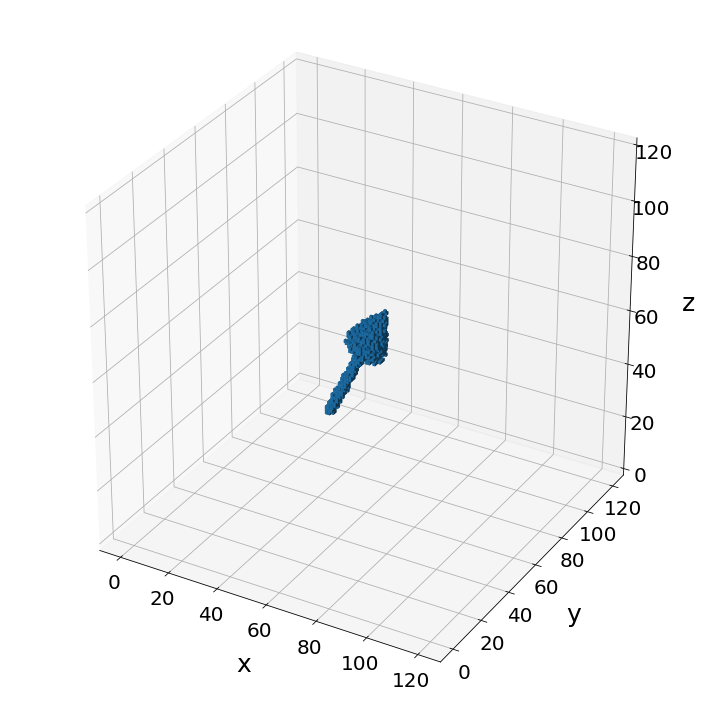

In [7]:
# Plot the tensor

# Convert to a dense, reshape, and story as numpy 
dense_tensor = vg.to_dense().reshape((1,Npix,Npix,Npix)).numpy()

# Convert direction and offset to numpy arrays
Ans = label

mytools.vox_plot_arrow(tensor = dense_tensor, eff_l = eff_l, vox_l = vox_l)

plt.tight_layout()
plt.savefig("arrow_pic.pdf")



# Make Training Dataset

In [10]:
n_train = 5000
data_loc = '/Users/majdghrear/data/e_dir_fit'


df_train = pd.DataFrame(columns = ['dir', 'offset'])

ind = 0
cnt = 0
for index in range(n_train):

    # Determine random direction to rotate to
    to_dir, theta, phi = mytools.random_three_vector()
    
    # Rotate all points to random direction drawn in previous step
    Rcoords = mytools.R_z(phi)@mytools.R_y(theta)@np.array((x_new,y_new,z_new))
    
    # compute the indices for the sparse tensor
    indices = torch.stack( ( (torch.tensor(Rcoords[0])+eff_l)/vox_l  , (torch.tensor(Rcoords[1])+eff_l)/vox_l, (torch.tensor(Rcoords[2])+eff_l)/vox_l ) ).type(torch.int16)

    # If arrow escapes fiducial area, skip it
    if torch.min(indices) < 0 or torch.max(indices) >= Npix:
        cnt += 1
    else:
        # Sparse Values indices
        values = torch.ones( (len(Rcoords[0]), 1) ).type(torch.float)
        vg = torch.sparse_coo_tensor(indices, values, dim)

        # Sum up duplicate entries in the sparse tensor above
        vg = vg.coalesce()
            
        # Add tensor info to new dataframe
        df_train = df_train.append({'dir': to_dir,'offset' :  np.array([0,0,0]) }, ignore_index = True)

        # Store sparse tensor and corresponding information
        torch.save( vg, data_loc+'/sparse_training_arrows/sparse_recoils_'+str(ind)+'.pt')
        ind += 1

print("Arrows not contained: ", cnt)

df_train.to_pickle(data_loc+'/sparse_training_arrows/sparse_tensor_info.pk')

df_train.head()



Arrows not contained:  0


,dir,offset
0,"[-0.21901664850274835, 0.5265499716031883, -0....","[0, 0, 0]"
1,"[0.6163518863561397, -0.005503427027638802, 0....","[0, 0, 0]"
2,"[-0.6471694153114912, -0.7611794141912354, -0....","[0, 0, 0]"
3,"[0.9523343909191598, -0.30492272014752914, 0.0...","[0, 0, 0]"
4,"[-0.8025988436739429, -0.4235082256992638, 0.4...","[0, 0, 0]"


# Make Testing Dataset

In [11]:
n_test = 1000
data_loc = '/Users/majdghrear/data/e_dir_fit'


df_test = pd.DataFrame(columns = ['dir', 'offset'])

ind = 0
cnt = 0
for index in range(n_test):

    # Determine random direction to rotate to
    to_dir, theta, phi = mytools.random_three_vector()
    
    # Rotate all points to random direction drawn in previous step
    Rcoords = mytools.R_z(phi)@mytools.R_y(theta)@np.array((x_new,y_new,z_new))
    
    # compute the indices for the sparse tensor
    indices = torch.stack( ( (torch.tensor(Rcoords[0])+eff_l)/vox_l  , (torch.tensor(Rcoords[1])+eff_l)/vox_l, (torch.tensor(Rcoords[2])+eff_l)/vox_l ) ).type(torch.int16)

    # If arrow escapes fiducial area, skip it
    if torch.min(indices) < 0 or torch.max(indices) >= Npix:
        cnt += 1
    else:
        # Sparse Values indices
        values = torch.ones( (len(Rcoords[0]), 1) ).type(torch.float)
        vg = torch.sparse_coo_tensor(indices, values, dim)

        # Sum up duplicate entries in the sparse tensor above
        vg = vg.coalesce()
            
        # Add tensor info to new dataframe
        df_test = df_test.append({'dir': to_dir,'offset' :  np.array([0,0,0]) }, ignore_index = True)

        # Store sparse tensor and corresponding information
        torch.save( vg, data_loc+'/sparse_testing_arrows/sparse_recoils_'+str(ind)+'.pt')
        ind += 1

print("Arrows not contained: ", cnt)

df_test.to_pickle(data_loc+'/sparse_testing_arrows/sparse_tensor_info.pk')

df_test.head()



Arrows not contained:  0


,dir,offset
0,"[-0.19599886999474228, 0.8528593436875164, 0.4...","[0, 0, 0]"
1,"[0.22486356846184327, 0.35994540251067464, -0....","[0, 0, 0]"
2,"[-0.5471225637250694, -0.14112552598636538, -0...","[0, 0, 0]"
3,"[0.7308492773130751, 0.6825335033937229, -0.00...","[0, 0, 0]"
4,"[0.5098176584027287, 0.580607269703131, 0.6348...","[0, 0, 0]"
